In [1]:
import numpy as np
import glob
import pypianoroll as ppr
import time
import music21
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from utils.utilsPreprocessing import *
#np.set_printoptions(threshold=np.inf)
#torch.set_printoptions(threshold=50000)

In [2]:
##################################
#HYPERPARAMS
##################################
epochs = 1
learning_rate = 5e-4
batch_size= 100
log_interval = 1  #Log/show loss per batch

# Load MIDI files from npz

In [3]:
data = np.load('/Volumes/EXT/DATASETS/WikifoniaPartlyNoTranspose.npz')

midiDatasetTrain = data['train']
midiDatasetTest = data['test']

data.close()

"""
print("Training set: ({}, {}, {}, {})".format(midiDatasetTrain.size()[0],
                                                midiDatasetTrain.size()[1],
                                                midiDatasetTrain.size()[2],
                                                midiDatasetTrain.size()[3]))
print("Test set: ({}, {}, {}, {})".format(midiDatasetTest.size()[0],
                                                midiDatasetTest.size()[1],
                                                midiDatasetTest.size()[2],
                                                midiDatasetTest.size()[3]))
"""

print("Training set: {}".format(midiDatasetTrain.shape))
print("Test set: {}".format(midiDatasetTest.shape))

Training set: (4056, 1, 96, 60)
Test set: (1034, 1, 96, 60)


In [4]:
#print(getSlicedPianorollMatrix('WikifoniaServer/train80/Ahmad-Jamal---Poinciana.mid').shape)

In [5]:
fullPitch = 128
_, _, length, reducedPitch = midiDatasetTrain.shape

# CDVAE

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
midiDatasetTrain = torch.from_numpy(midiDatasetTrain)#.float()
trainLoader = torch.utils.data.DataLoader(midiDatasetTrain, batch_size=batch_size, shuffle=True, drop_last=True)

midiDatasetTest = torch.from_numpy(midiDatasetTest)#.float()
testLoader = torch.utils.data.DataLoader(midiDatasetTest, batch_size=batch_size, shuffle=True, drop_last=True)

In [15]:
class CDVAE(nn.Module):
    def __init__(self):
        super(CDVAE, self).__init__()
        
        ###ENCODER###
        self.encode1 = nn.Sequential(
            nn.Conv2d(1,100,(16,5),stride=(16,5),padding=0),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.Conv2d(100,200,(2,1),stride=(2,1),padding=0),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.Conv2d(200,400,(2,2),stride=(1,2),padding=0),
            nn.BatchNorm2d(400),
            nn.ELU(),
            nn.Conv2d(400,800,(2,2),stride=(2,2),padding=0),
            nn.BatchNorm2d(800),
            nn.ELU()
        )
            
        self.encode2 = nn.Sequential(
            nn.Linear(2400,800),
            nn.BatchNorm1d(800),
            nn.ELU(),
            nn.Linear(800,400),
            nn.BatchNorm1d(400),
            nn.ELU()
            #nn.Linear(400,100),
            #nn.BatchNorm1d(100),
            #nn.ELU()
        )
        self.encode3 = nn.Sequential(
            nn.Linear(400,100),
            nn.BatchNorm1d(100),
            nn.ELU()
        )

        ###DECODER###
        self.decode1 = nn.Sequential(
            nn.Linear(100,400),
            nn.BatchNorm1d(400),
            nn.ELU(),
            nn.Linear(400,800),
            nn.BatchNorm1d(800),
            nn.ELU(),
            nn.Linear(800,2400),
            nn.BatchNorm1d(2400),
            nn.ELU()
        )
        self.decode2 = nn.Sequential(
            nn.ConvTranspose2d(800,400,(2,2),stride=(2,2),padding=0),
            nn.BatchNorm2d(400),
            nn.ELU(),
            nn.ConvTranspose2d(400,200,(2,2),stride=(1,2),padding=0),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.ConvTranspose2d(200,100,(2,1),stride=(2,1),padding=0),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.ConvTranspose2d(100,1,(16,5),stride=(16,5),padding=0),
            nn.BatchNorm2d(1),
            nn.ELU()
        )
    
    def encoder(self, x):
        #print("ENOCDER")
        hEnc = self.encode1(x)
        hEnc = torch.squeeze(hEnc,3).view(-1,800*3)
        hEnc = self.encode2(hEnc)
        hEnc1 = self.encode3(hEnc)
        hEnc2 = self.encode3(hEnc)
        return hEnc1, hEnc2

    def decoder(self, z):
        #print("DECODER")
        hDec = self.decode1(z)
        hDec = hDec.view(hDec.size()[0],800,-1).unsqueeze(2)
        hDec = self.decode2(hDec)
        return hDec

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.2*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            print("no change")
            return mu
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    
model = CDVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def loss_function(recon_x, x, mu, logvar, dataset):
    
    cos = nn.CosineSimilarity(dim=1, eps=1e-8) 
    #beta for disentanglement
    beta = 5e0 
    
    ###NESTED COSINE SIMILARITY SOFTMAX LOSS 
    ###WITH 4 RANDOM RECONSTRUCTED VECTORS
    ###WHICH INCLUDES NEGATIVE EXAMPLES OF RECONSTRUCTIONS
    if(False):#model.training): 
        sftmax = nn.Softmax(dim=0)
        lenDataset = dataset.size()[0]
        #print(lenDataset)
        softmax = 0
        for orgInput, recon in zip(x, recon_x):
                     
            #HAVE TO DO IT LIKE THIS BECAUSE BATCHSIZE 1 DOESN'T WORK IN PYTORCH
            rand = np.random.randint(0,lenDataset-1)
            randomRecons = dataset[rand:rand+1,:,:,:] 
            for i in range(3):
                rand = np.random.randint(0,lenDataset-1)
                randomTemp = dataset[rand:rand+1,:,:,:]
                randomRecons = torch.cat((randomRecons,randomTemp),dim=0)
            with torch.no_grad():
                randomRecons, _ = model(randomRecons.float().to(device))
            #COMPUTE COSINE SIMILARITY FOR ORIGINAL INPUT
            #AND ITS RECONSTRUCTION
            cosSimOrg = cos(orgInput.view(1,-1),recon.view(1,-1))
            
            #INCLUDE NEGATIVE EXAMPLES WITH SOFTMAX
            cosSim = cos(orgInput.view(1,-1),randomRecons[0].view(1,-1))
            for randomRecon in randomRecons[1:]:
                cosTemp = cos(orgInput.view(1,-1),randomRecon[0].view(1,-1))
                cosSim = torch.cat((cosSim, cosTemp),dim=0)
            cosSoftmax = torch.cat((cosSimOrg,cosSim),dim=0)            
            softmax += sftmax(cosSoftmax)[0]
            
        return -softmax
    #OLDLOSS JUST COSINE SIMILARITY ON RECONSTRUCTION (GOOD FOR TESTING?)
    else:
        """
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD
        """
        
        cosSim = torch.sum(cos(x.view(100,-1),recon_x.view(100,-1)))
        cosSim = x.size()[0]-cosSim
        #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        #KLD /= x.size()[0]
        return cosSim# + (beta * KLD)
        

def train(epoch):
    model.train()
    trainLoss = 0

    for batch_idx, data in enumerate(trainLoader):
        ###DENOISING AUTOENCODER
        #data = data.float().to(device)
        #noise = torch.bernoulli((torch.rand_like(data))).to(device)
        #print(noise[0])
        #noisyData = data+noise
        #optimizer.zero_grad()
        #reconBatch, mu = model(noisyData)
        
        ###NORMAL AUTOENCODER
        data = data.float().to(device)
        reconBatch, mu, logvar = model(data)

        loss = loss_function(reconBatch, data, mu, logvar, trainLoader.dataset)
        loss.backward()
        trainLoss += loss.item()
        optimizer.step()
        if(batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainLoader.dataset),
                100. * batch_idx / len(trainLoader),
                loss.item() / len(data)))
        #if (batch_idx == 10):
        #    break

    print('====> Epoch: {} Average Loss: {:.4f}'.format(
          epoch, trainLoss / len(trainLoader.dataset)))

def test(epoch):
    model.eval()
    testLoss = 0
    with torch.no_grad():
        for i, data in enumerate(testLoader):
            ###DENOISING AUTOENCODER
            #data = data.float().to(device)
            #noise = torch.bernoulli((torch.rand_like(data))).to(device)
            #noisyData = data+noise
            #reconBatch, mu = model(noisyData)
            
            ###NORMAL AUTOENCODER
            data = data.float().to(device)
            reconBatch, mu, logvar = model(data)
            
            #TEMP
            randomRecons = torch.zeros(1,1,60,96).to(device)
            #TEMP END
            testLoss += loss_function(reconBatch, data, mu, logvar, randomRecons).item()
            
            #if(i==10):
            #    break
    testLoss /= len(testLoader.dataset)

    print('====> Test set loss: {:.4f}'.format(testLoss))

In [17]:

from collections import OrderedDict

pathToModel = '../models/YamahaPC2002_DenoisingCVAE_Reconstruct_1Epoch_NoTW.model'

#WAS THIS MODEL TRAINED WITH DATAPARALLEL?
dataParallelModel = True

try:
    #LOAD TRAINED MODEL INTO GPU
    if(torch.cuda.is_available()):
        model = torch.load(pathToModel)
        print("\n--------model restored--------\n")

    #LOAD MODEL TRAINED ON GPU INTO CPU
    elif(dataParallelModel):
        #model = torch.load(pathToModel, map_location=lambda storage, loc: storage)
        #model.load_state_dict(torch.load(pathToModel, map_location=lambda storage, loc: storage))
        state_dict = torch.load(pathToModel, map_location=lambda storage, loc: storage)
        #print(state_dict)
        #state_dict = model.state_dict()
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            #print(name)
            if k[0] == 'm':
                new_state_dict[name] = v
            else:
                new_state_dict[k] = v

        model.load_state_dict(new_state_dict)
        print("\n--------GPU data parallel model restored--------\n")
    else:
        #storage = {"cuda":"cpu"}
        model = torch.load(pathToModel, map_location=lambda storage, loc: storage)
        print("\n--------GPU model restored--------\n")
except:
    print("\n--------no saved model found--------\n")

print('')


--------GPU data parallel model restored--------




In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

In [ ]:
#torch.save(model,'/media/EXTHD/niciData/models/YamahaPC2002_DenoisingCVAE_Reconstruct_NoTW_5Epochs.model')

In [ ]:
np.set_printoptions(precision=2, suppress=True, threshold=np.inf)


no change
torch.Size([1, 1, 96, 60])
tensor([[[[ 3.7318,  4.2009,  4.1837,  ...,  4.0130,  4.3195,  3.2435],
          [ 3.4312,  3.7870,  4.2330,  ...,  3.7741,  4.1446,  3.3523],
          [ 3.8458,  4.0061,  4.4808,  ...,  3.9353,  4.1933,  3.4761],
          ...,
          [ 2.1443,  3.6784,  3.5847,  ...,  3.8575,  4.0377,  3.5898],
          [ 2.8168,  3.9868,  4.1284,  ...,  4.1876,  3.7435,  3.6862],
          [ 2.7871,  3.9682,  4.1828,  ...,  4.3246,  3.4745,  3.6704]]]])
(96, 60)
[[3.7317686 4.2008734 4.1836677 ... 4.013025  4.3194504 3.2434607]
 [3.4311829 3.7870293 4.232963  ... 3.7741423 4.144562  3.3523474]
 [3.845766  4.006114  4.4807763 ... 3.9352922 4.193285  3.4760866]
 ...
 [2.1443415 3.678424  3.584672  ... 3.8574657 4.037684  3.5897512]
 [2.8167515 3.9867954 4.128355  ... 4.1875596 3.7435408 3.6861782]
 [2.787075  3.9682045 4.182845  ... 4.3246336 3.474474  3.6703777]]
INPUT


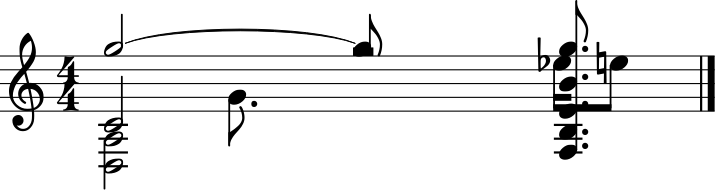

RECONSTRUCTION


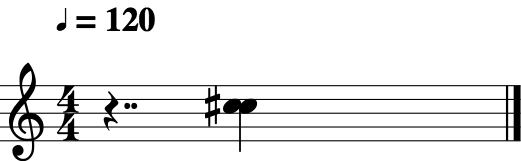




no change
torch.Size([1, 1, 96, 60])
tensor([[[[  3.4484,   2.2481,   2.9731,  ...,   3.7442,   3.6834,   1.9339],
          [  3.3264,   2.1118,   2.6807,  ...,   3.3103,   3.7021,   2.5219],
          [  3.4513,   2.5544,   2.9969,  ...,   3.5432,   3.3130,   2.6577],
          ...,
          [  1.5709,   2.4573,   2.4549,  ...,   3.1323,   3.7565,   3.1074],
          [  2.3969,   2.9106,   2.9264,  ...,   3.6908,   3.2890,   3.0590],
          [  2.3712,   2.5631,   3.2363,  ...,   4.2424,   3.3680,   3.3307]]]])
(96, 60)
[[3.448368  2.248066  2.973112  ... 3.7442284 3.6834202 1.9339075]
 [3.326356  2.111846  2.680729  ... 3.310336  3.7021446 2.5219316]
 [3.451293  2.5543976 2.9968548 ... 3.5432024 3.3130016 2.6576624]
 ...
 [1.5709105 2.457324  2.4549198 ... 3.1322737 3.7565203 3.1073856]
 [2.3968601 2.9106493 2.9264393 ... 3.6908302 3.2889786 3.0589638]
 [2.3711815 2.5630884 3.236309  ... 4.242415  3.36796   3.330738 ]]
INPUT


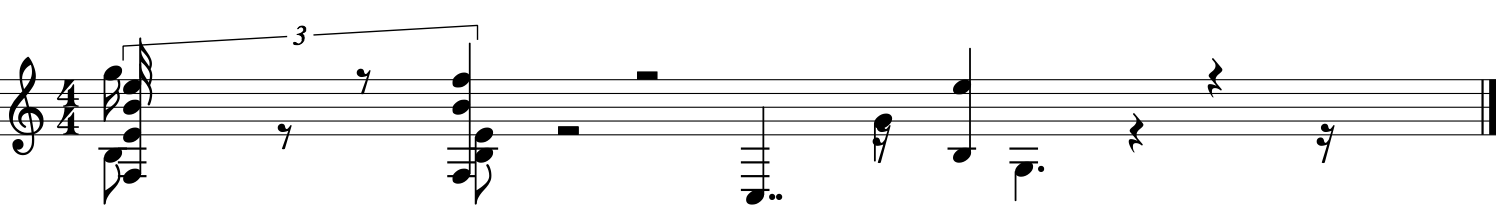

RECONSTRUCTION


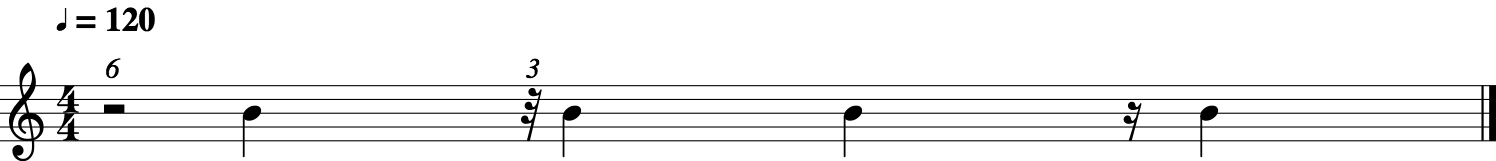




no change
torch.Size([1, 1, 96, 60])
tensor([[[[ 8.6630e-01,  6.6259e+00,  7.4293e+00,  ...,  4.5778e+00,
            4.9894e+00,  4.7153e+00],
          [ 4.3993e-01,  6.2880e+00,  7.4400e+00,  ...,  4.6926e+00,
            5.3157e+00,  4.4598e+00],
          [ 2.9444e+00,  4.9598e+00,  7.9711e+00,  ...,  4.9186e+00,
            5.0954e+00,  4.6539e+00],
          ...,
          [ 1.9967e-01,  4.4941e+00,  8.1239e+00,  ...,  5.1857e+00,
            5.4576e+00,  5.3800e+00],
          [ 2.3045e+00,  6.5989e+00,  8.5148e+00,  ...,  5.4686e+00,
            5.3661e+00,  5.6350e+00],
          [ 2.5918e+00,  5.3728e+00,  6.6232e+00,  ...,  5.4628e+00,
            4.9843e+00,  5.3311e+00]]]])
(96, 60)
[[0.8662958  6.625866   7.429332   ... 4.5778174  4.9893613  4.715318  ]
 [0.43992996 6.288027   7.440001   ... 4.692606   5.3156567  4.459844  ]
 [2.9444046  4.9597793  7.9711103  ... 4.9185915  5.095437   4.653896  ]
 ...
 [0.1996746  4.4941     8.123938   ... 5.1857133  5.457612   5.3799

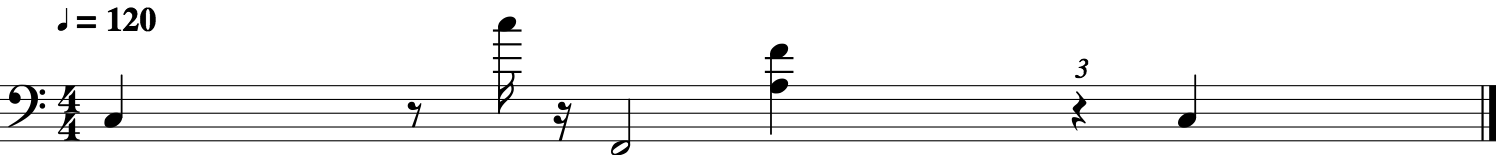

RECONSTRUCTION


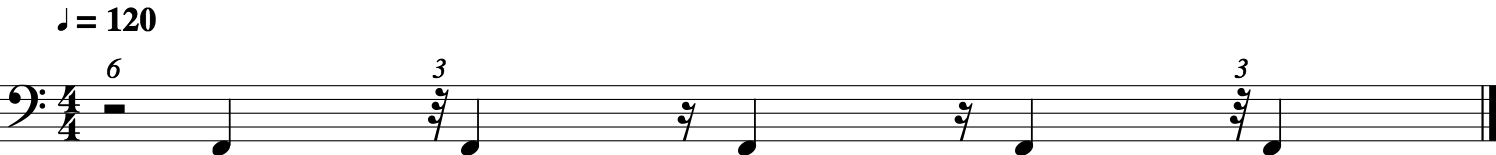




no change
torch.Size([1, 1, 96, 60])
tensor([[[[ 5.8293,  9.8011,  9.4325,  ...,  4.4395,  4.8737,  4.4816],
          [ 5.5778,  9.8546, 10.2075,  ...,  4.4471,  5.0635,  4.2177],
          [ 6.0022,  9.9782, 10.2589,  ...,  4.6738,  4.9265,  4.3789],
          ...,
          [ 5.1355,  9.5547,  9.2593,  ...,  5.0158,  5.1594,  5.0260],
          [ 5.4979,  9.3310,  9.3875,  ...,  5.2913,  5.0646,  5.2908],
          [ 5.2236,  9.9766,  9.7831,  ...,  5.2348,  4.6492,  4.9882]]]])
(96, 60)
[[ 5.829342   9.801115   9.4324665 ...  4.4395366  4.8737397  4.4815984]
 [ 5.5778337  9.854601  10.207506  ...  4.4470725  5.0634613  4.217652 ]
 [ 6.0021696  9.978194  10.258904  ...  4.6737976  4.926523   4.3789153]
 ...
 [ 5.13548    9.554733   9.25932   ...  5.01582    5.1593785  5.0259895]
 [ 5.497946   9.331032   9.387479  ...  5.2913103  5.064606   5.2907796]
 [ 5.223622   9.976649   9.783138  ...  5.234801   4.649212   4.9881535]]
INPUT


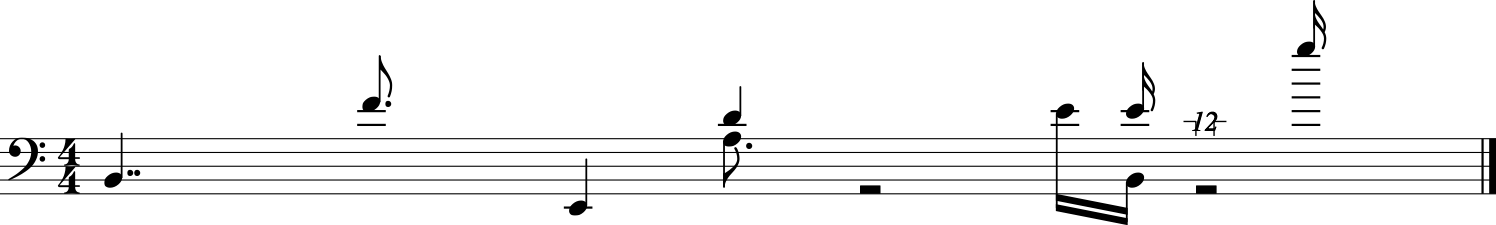

RECONSTRUCTION


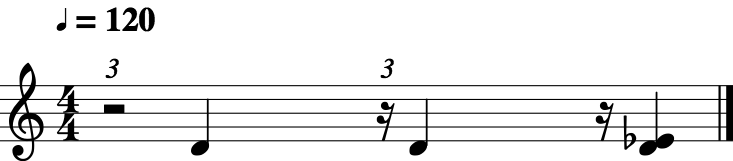




no change
torch.Size([1, 1, 96, 60])
tensor([[[[ 5.4551,  9.0620,  8.6215,  ..., 25.5961, 29.8328, 30.6366],
          [ 5.2830,  9.1418,  9.1529,  ..., 27.6300, 30.3884, 29.6364],
          [ 5.7262,  9.2528,  9.2730,  ..., 27.7722, 29.8143, 29.4116],
          ...,
          [ 4.7376,  9.0361,  8.6927,  ..., 29.9561, 34.0145, 32.3158],
          [ 4.8750,  8.6889,  8.7557,  ..., 30.7639, 29.7853, 33.7471],
          [ 4.7727,  9.1098,  8.9443,  ..., 28.8332, 31.2361, 30.8797]]]])
(96, 60)
[[ 5.455083   9.062006   8.621536  ... 25.596058  29.832848  30.636597 ]
 [ 5.2829523  9.141768   9.152937  ... 27.629986  30.388435  29.636372 ]
 [ 5.7262425  9.252805   9.272982  ... 27.77224   29.814316  29.411613 ]
 ...
 [ 4.7375827  9.0360565  8.692743  ... 29.956116  34.014477  32.31579  ]
 [ 4.874968   8.688902   8.755653  ... 30.763851  29.78526   33.74708  ]
 [ 4.7726603  9.109751   8.9443245 ... 28.833172  31.236149  30.879704 ]]
INPUT


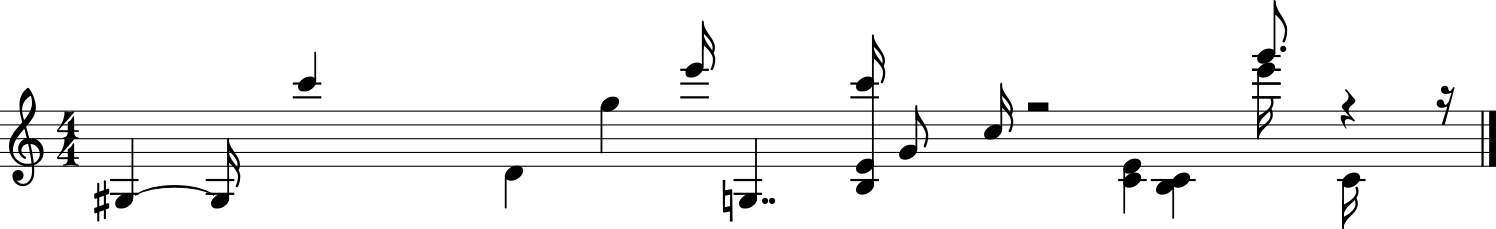

RECONSTRUCTION


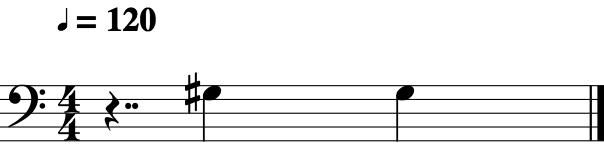




no change
torch.Size([1, 1, 96, 60])
tensor([[[[ 3.6266,  3.0153,  3.4780,  ...,  3.9311,  4.3111,  3.3769],
          [ 3.4601,  2.8216,  3.2950,  ...,  3.6957,  4.0971,  3.3290],
          [ 3.7149,  3.1224,  3.5720,  ...,  3.8674,  4.2116,  3.4099],
          ...,
          [ 1.8615,  3.1447,  3.0850,  ...,  3.8052,  3.9515,  3.5274],
          [ 2.4494,  3.4206,  3.5048,  ...,  4.1695,  3.6691,  3.7075],
          [ 2.5025,  3.1377,  3.6207,  ...,  4.1761,  3.3292,  3.5443]]]])
(96, 60)
[[3.6265984 3.0152683 3.4779606 ... 3.931139  4.3110714 3.3768597]
 [3.4600573 2.8215704 3.2949533 ... 3.6957226 4.097139  3.32899  ]
 [3.7148857 3.1223955 3.5720348 ... 3.8674374 4.2115736 3.4099283]
 ...
 [1.8615246 3.144743  3.0850487 ... 3.805151  3.951468  3.5274124]
 [2.4493818 3.4205866 3.5047941 ... 4.1694593 3.6691074 3.7074747]
 [2.5024986 3.1377277 3.6206856 ... 4.1760683 3.3292189 3.5443058]]
INPUT


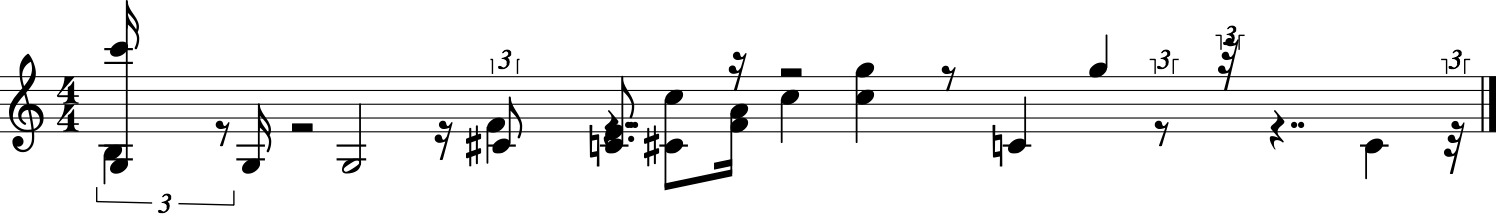

RECONSTRUCTION


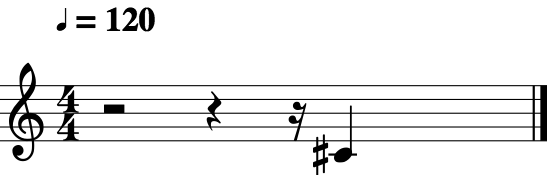




no change
torch.Size([1, 1, 96, 60])
tensor([[[[ 3.6830,  3.2632,  3.5534,  ...,  3.9226,  4.2696,  3.2746],
          [ 3.4599,  2.9408,  3.4156,  ...,  3.6853,  4.0767,  3.2939],
          [ 3.7891,  3.2432,  3.7025,  ...,  3.8529,  4.1528,  3.3977],
          ...,
          [ 1.9357,  3.2429,  3.1581,  ...,  3.7706,  3.9363,  3.4992],
          [ 2.5637,  3.5354,  3.6357,  ...,  4.1222,  3.6431,  3.6336],
          [ 2.5833,  3.3457,  3.7250,  ...,  4.1934,  3.3383,  3.5447]]]])
(96, 60)
[[3.682993  3.2632065 3.5533514 ... 3.922552  4.2696333 3.2746239]
 [3.4598799 2.9407825 3.4155903 ... 3.6852932 4.0767374 3.2939014]
 [3.7891417 3.2432003 3.7024984 ... 3.8529167 4.152847  3.397709 ]
 ...
 [1.9356556 3.242856  3.1580563 ... 3.7705517 3.9363441 3.4991941]
 [2.5636501 3.5353966 3.635706  ... 4.1221614 3.643096  3.6335506]
 [2.5833025 3.3456535 3.7250128 ... 4.1934    3.3383474 3.5447226]]
INPUT


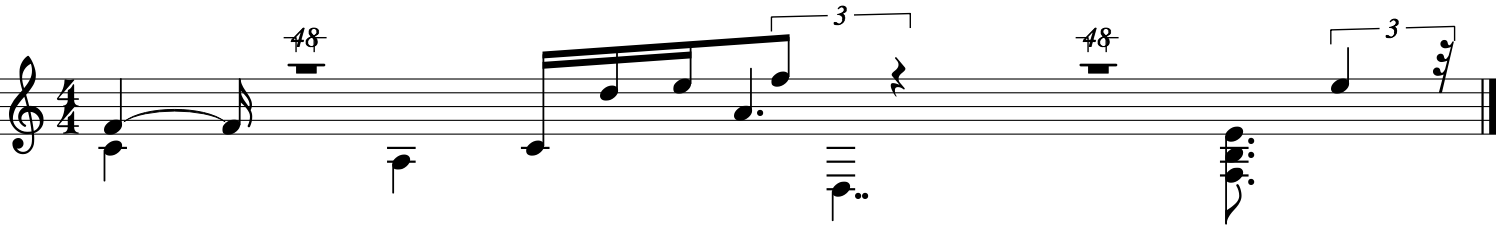

RECONSTRUCTION


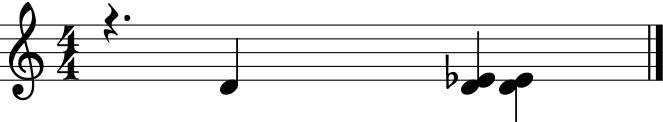




no change
torch.Size([1, 1, 96, 60])
tensor([[[[  3.3851,   2.5485,   3.3679,  ...,   5.0632,   4.5653,   2.3576],
          [  3.3437,   2.5945,   3.0799,  ...,   4.4249,   4.2525,   3.5568],
          [  3.4611,   2.8220,   3.3291,  ...,   4.5550,   4.1347,   3.6753],
          ...,
          [  1.6654,   2.7063,   2.6930,  ...,   3.7251,   4.3023,   3.5754],
          [  2.3477,   3.0693,   3.0806,  ...,   4.3537,   3.8168,   3.5166],
          [  2.3963,   2.6175,   3.3654,  ...,   5.0867,   4.0434,   3.9060]]]])
(96, 60)
[[3.3851137 2.5484743 3.3679075 ... 5.063222  4.5653477 2.3576088]
 [3.343749  2.5945234 3.0799065 ... 4.424923  4.252532  3.556755 ]
 [3.4610977 2.8219967 3.329114  ... 4.5549803 4.134725  3.6752691]
 ...
 [1.665391  2.7062721 2.6930113 ... 3.7250967 4.3022757 3.575366 ]
 [2.3477097 3.0692892 3.0805836 ... 4.3537364 3.8167562 3.5165977]
 [2.3963394 2.6174946 3.3653889 ... 5.086725  4.04345   3.906043 ]]
INPUT


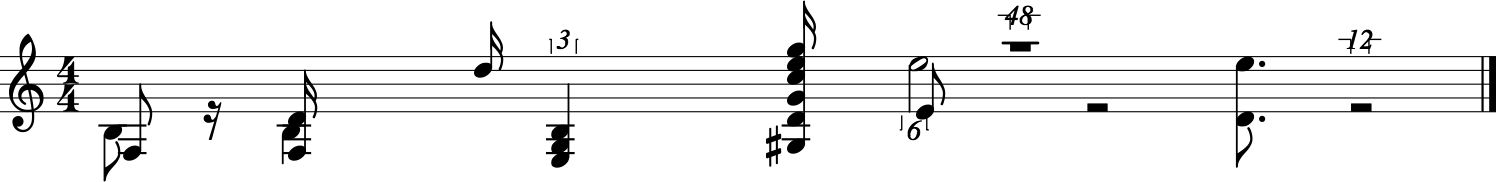

RECONSTRUCTION


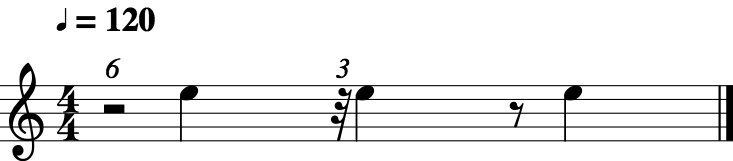




no change
torch.Size([1, 1, 96, 60])
tensor([[[[ 3.5888,  2.4963,  3.9120,  ...,  5.0641,  5.0636,  3.5808],
          [ 3.8879,  2.9093,  3.3000,  ...,  4.6239,  4.7777,  4.1536],
          [ 3.7922,  2.7768,  3.5326,  ...,  4.7622,  4.8953,  4.2580],
          ...,
          [ 2.4995,  3.2574,  2.7807,  ...,  4.6729,  4.5998,  4.1732],
          [ 3.1216,  3.7035,  3.3884,  ...,  4.9311,  4.3495,  4.2867],
          [ 3.3143,  2.6757,  4.1871,  ...,  5.0984,  4.1051,  4.3083]]]])
(96, 60)
[[3.5887728 2.4962645 3.9120493 ... 5.0641174 5.0635557 3.5808306]
 [3.8879013 2.909337  3.3000326 ... 4.623908  4.777729  4.1535964]
 [3.792244  2.77676   3.5325956 ... 4.762168  4.895255  4.257955 ]
 ...
 [2.4995108 3.2573767 2.7806635 ... 4.672871  4.5998006 4.173248 ]
 [3.1216145 3.7035398 3.388445  ... 4.931051  4.3495107 4.286662 ]
 [3.3143444 2.6757326 4.1871333 ... 5.0983834 4.105143  4.3083334]]
INPUT


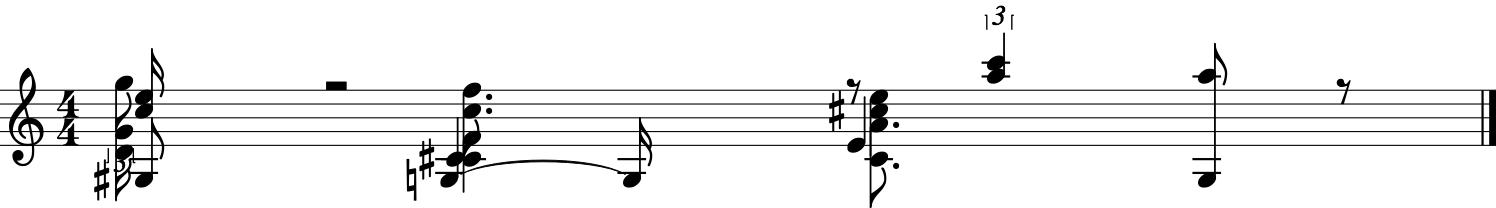

RECONSTRUCTION


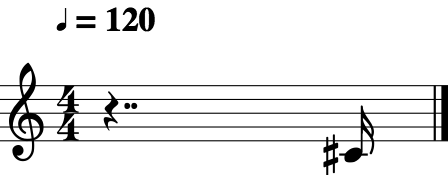




no change
torch.Size([1, 1, 96, 60])
tensor([[[[ 3.4404,  2.8985,  3.3419,  ...,  3.8572,  4.2239,  3.2382],
          [ 3.3341,  2.7399,  3.0405,  ...,  3.6080,  4.0145,  3.2202],
          [ 3.5674,  2.6105,  3.2672,  ...,  3.7814,  4.0981,  3.3071],
          ...,
          [ 1.7814,  2.8284,  2.8565,  ...,  3.7022,  3.8721,  3.4293],
          [ 2.3273,  3.1546,  3.2754,  ...,  4.0625,  3.5731,  3.5819],
          [ 2.4785,  2.7215,  3.3481,  ...,  4.1097,  3.2583,  3.4616]]]])
(96, 60)
[[3.4404469 2.8984604 3.341938  ... 3.857195  4.2238975 3.2381725]
 [3.3340902 2.739851  3.0404787 ... 3.607998  4.0144615 3.2202272]
 [3.5674343 2.6104794 3.2672234 ... 3.7813883 4.098128  3.3070898]
 ...
 [1.7813873 2.8283777 2.856492  ... 3.7022495 3.8721313 3.429268 ]
 [2.3272867 3.1546211 3.275446  ... 4.062498  3.5731277 3.581913 ]
 [2.478506  2.721469  3.3481007 ... 4.1096916 3.2583237 3.461629 ]]
INPUT


SubConverterFileIOException: png file of xml not found. Or file >999 pages?

In [18]:
if(model.train()):
    model.eval()
###PLAY WHOLE SONG IN BARS
with torch.no_grad():
    
    sampleNp1 = getSlicedPianorollMatrixNp("../DougMcKenzieFiles_noDrums/samples/AliceInWonderland.mid")
    for sampleNp in sampleNp1:
        
        if(np.any(sampleNp)):
            #sampleNp = sampleNp[12,:,:]
            #print(sampleNp)
            sampleNp = sampleNp[:,36:-32]
            sample = torch.from_numpy(sampleNp).float()
            pred, embed, logvar = model(sample.reshape(1,1,length,reducedPitch).to(device))
            print(pred.size())
            print(pred)
            prediction = pred.squeeze(0).squeeze(0).cpu().numpy()
            print(prediction.shape)
            print(prediction)
            #print(sampleNp[:,:])
            #print(prediction[:,:])
            #print(np.sum(sampleNp.numpy(), axis=1))
            
            #NORMALIZE PREDICTIONS
            prediction /= np.abs(np.max(prediction))
            
            #CHECK MIDI ACTIVATIONS IN PREDICTION TO INCLUDE RESTS
            prediction[prediction < 0.99] = 0

            

            ###MONOPHONIC OUTPUT MATRIX POLOYPHONIC POSSIBLE WITH ACTIVATION THRESHOLD###
            #score = music21.converter.parse('WikifoniaServer/samples/The-Doors---Don\'t-you-love-her-Madly?.mid')
            #score.show()

            samplePlay = debinarizeMidi(sampleNp, prediction=False)
            samplePlay = addCuttedOctaves(samplePlay)
            prediction = debinarizeMidi(prediction, prediction=True)
            prediction = addCuttedOctaves(prediction)
            #print(np.argmax(samplePlay, axis=1))
            #print('')
            #print(np.argmax(prediction, axis=1))
            print("INPUT")
            pianorollMatrixToTempMidi(samplePlay, show=True,showPlayer=True,autoplay=False)
            #time.sleep(1)
            print("RECONSTRUCTION")
            pianorollMatrixToTempMidi(prediction, show=True,showPlayer=True,autoplay=False)        
            print("\n\n")
            

print('')